In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gym
import numpy as np
import matplotlib.pyplot as plt
import sys, os
from IPython.display import clear_output
from typing import *

In [2]:
class Network(nn.Module):
    def __init__(self, obs_dim: int, act_dim: int):
        super(Network, self).__init__()

        self.obs_dim = obs_dim
        self.act_dim = act_dim
        self.fc1 = nn.Linear(self.obs_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, self.act_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [3]:
class ReplayBuffer:
    def __init__(self, memory_size: int, batch_size: int):
        self.size = 0
        self.tran_size = 11    ## transition s, a, r, s', d
        self.batch_size = batch_size
        self.max_size = memory_size
        self.sample_index = []
        self.train_batch = []
        self.ptr = 0
        
        self.replay = np.zeros([self.max_size, self.tran_size], dtype=np.float32)

    def store(self, 
              obs: np.ndarray,
              action: int,
              reward: float,
              next_obs: np.ndarray,
              done: bool,
              ):
        self.replay[self.ptr, :4] = obs
        self.replay[self.ptr, 4:5] = action
        self.replay[self.ptr, 5:6] = reward
        self.replay[self.ptr, 6:10] = next_obs
        self.replay[self.ptr, 10:11] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)


    def sample_batch(self) -> List[int]:
        sample_index = np.random.randint(low=0, high=self.size, size=self.batch_size) ##### local로 만들어줌
        train_batch = np.array([self.replay[idx] for idx in sample_index]) ##### local로 만들어줌
        return train_batch

In [5]:
class Agent:
    def __init__(self, 
                 env: gym.Env,
                 memory_size: int,
                 batch_size: int,
                 target_update: int,
                 epsilon_decay: float,
                 max_epsilon: float = 1.0,
                 min_epsilon: float = 0.1,
                 gamma: float = 0.99):
        
        self.env = env
        self.batch_size = batch_size
        self.memory = ReplayBuffer(memory_size, batch_size)
        self.target_update = target_update
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.gamma = gamma

        self.obs_dim = env.observation_space.shape[0]
        self.act_dim = env.action_space.n

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  ####### 필요성 이해하고 넣어줌

        self.dqn = Network(self.obs_dim, self.act_dim).to(self.device) # to 
        self.dqn_target = Network(self.obs_dim, self.act_dim).to(self.device)# to
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        self.optimizer = optim.Adam(self.dqn.parameters())  ####### optimizer 선언을 안 해줬었네


    def update_model(self):

        train_batch = self.memory.sample_batch()

        loss = self.compute_loss(train_batch)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()


    def compute_loss(self, train_batch):

        s = torch.FloatTensor(np.array([i[:4] for i in train_batch])).to(self.device)
        a = torch.LongTensor(np.array([i[4:5] for i in train_batch])).view([-1, 1]).to(self.device)
        r = torch.FloatTensor(np.array([i[5:6] for i in train_batch])).view([-1, 1]).to(self.device)
        next_s = torch.FloatTensor(np.array([i[6:10] for i in train_batch])).to(self.device)
        d = torch.BoolTensor(np.array([i[10] for i in train_batch])).view([-1, 1]).to(self.device)
        
        curr_value = self.dqn(s).gather(1, a)
        next_value = self.dqn_target(next_s).max(dim=1, keepdim=True)[0].detach()

        mask =  1 - d.type(torch.int32)
        target = (r + self.gamma * next_value * mask).to(self.device)

        loss = F.mse_loss(curr_value, target)

        return loss


    def train(self, num_episodes: int, plot_interval: int):
        
        update_cnt = 0
        losses = []
        score = 0
        scores = []

        for iter in range(1, num_episodes + 1):

            s = self.env.reset()
            d = False
            
            while (not d):
                #self.env.render() #######

                if self.epsilon > np.random.rand(): ### rand() 로 변경 --> 0 ~ 1 사이 uniformly sample
                    a = self.env.action_space.sample()
                else:
                    a = self.dqn.forward(torch.FloatTensor(s).to(self.device)).argmax() ####### 아래 코드랑 둘 중에 뭐가 맞는 걸까?
                  # a = self.dqn(torch.FloatTensor(s).to(self.device)).argmax()
                    a = a.detach().cpu().numpy()    

                next_s, r, d, _ = self.env.step(a)
                self.memory.store(s, a, r, next_s, d)
                s = next_s
                score += r
                
                if d:
                    scores.append(score)
                    score = 0

                if self.memory.size >= self.batch_size:  ## len 제거함
                    loss = self.update_model()
                    losses.append(loss)
                    update_cnt += 1

                    self.epsilon = max(self.min_epsilon,
                                    self.epsilon - self.epsilon_decay * (self.max_epsilon - self.min_epsilon))

                    if update_cnt % self.target_update == 0:
                        self.dqn_target.load_state_dict(self.dqn.state_dict())

                if iter % plot_interval == 0:
                    clear_output(True)
                    plt.figure(figsize=(20, 5))
                    plt.subplot(121)
                    plt.title('iter %s. score: %s' % (iter, np.mean(scores[-10:]))) ## 가장 최근 10개 에피소드 평균 score 출력
                    plt.plot(scores)
                    plt.subplot(122)
                    plt.title('loss')
                    plt.plot(losses)
                    plt.show()

In [6]:
env = gym.make('CartPole-v0')
memory_size = 1000
batch_size = 32
target_update = 100
epsilon_decay = 1 / 2000

agent = Agent(env, memory_size, batch_size, target_update, epsilon_decay)

C:\Users\LoteeYoon\anaconda3\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


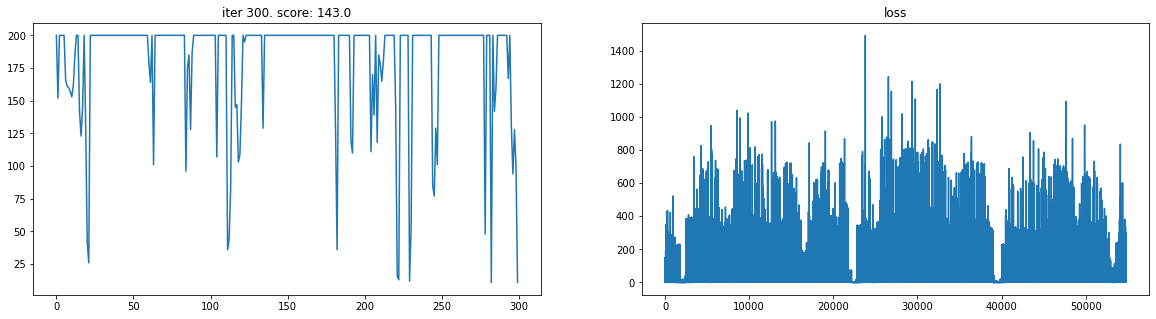

In [9]:
num_episodes = 300
plot_interval = 100

agent.train(num_episodes, plot_interval)